# Diving into the Housing Market

**A few goals of this notebook**
1. Explore the housing data
2. Univariate + Multivariate analysis
3. Crime correlation to price
4. Modelling (Boosted trees vs GLM)

In [35]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()


import warnings
warnings.filterwarnings('ignore')
sns.set()

df = pd.read_csv('./data/train.csv')
df[:4]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


<AxesSubplot:xlabel='SalePrice'>

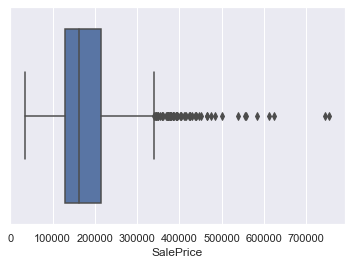

In [36]:
sns.boxplot(df['SalePrice'])

In [40]:
df.loc[((df['SalePrice'] <= 550000) & (df['SalePrice'] >= 175000))]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [2]:
n_cols = df.select_dtypes(['int','float']).columns.tolist()
obj_cols = df.select_dtypes('object').columns.tolist()

# Feat Eng

In [3]:
def feat_eng(frame, cols, test_set = False): 
    
    norm = [ 'GrLivArea',
        '1stFlrSF',
        'LotArea',
        ]
        
    if test_set == True:
        pass
    else:
        norm.append('SalePrice')
    
    # Encode Variabels
    for i in obj_cols: 
        frame[i] = frame[i].fillna('None')
        frame[i] = le.fit_transform(frame[i])

    
    # Log normalize vars
    frame[norm] = np.log1p(frame[norm])             


    return frame                       


df = feat_eng(df, obj_cols)

In [19]:

train = df[n_cols+obj_cols]
cols = n_cols + obj_cols
print(train.columns)



Index(['SalePrice', 'GrLivArea', 'OverallQual', 'GarageCars', 'YearBuilt',
       'FullBath', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'TotRmsAbvGrd',
       'GarageYrBlt', 'YearRemodAdd', 'OpenPorchSF', 'LotArea', 'MasVnrArea',
       'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


# Train Base Model 

In [20]:
train.loc[train['SalePrice'] <=]
train = train.fillna(train[cols].mean())

# Set Training and Test Set

In [22]:
X = train.drop(columns=['SalePrice'])
for i in obj_cols: 
    X[i] = le.fit_transform(X[i])

y = train['SalePrice']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=.8)

# Cross Validation
**Test Multiple LR Models**

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor as lgbm

linear_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = lgbm()

lgb_params = {
    'n_estimators' : [10,15,20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70 , 75,100,200],
    'num_leaves': [2,3,5,7,10,15,20,25,50,75,100],
    'max_depth':[1,2,5,10,15,20,25,50],
    'learning_rate':[.005, .05,.1,.11,.12,.13,.14,.15,.2]
            }

linear_params = {
    'normalize' : [False]
}
            
rf_params = {
    'n_estimators' : [10,15,20, 25,50,75,100,200],    
}

lgb_scores = list()
rf_scores = list()
lr_scores = list()

lgb_best = list()
rf_best = list()
lr_best = list()

models = [lgb_model,]  #  rf_model, linear_model
params = [lgb_params,] #  rf_params, linear_params
scores = [lgb_scores,] #rf_scores, lr_scores
best_params = [lgb_best,]  # rf_best,lr_best

kfold = KFold(n_splits=5, shuffle=True)
for model, parameters, score, best in zip(models, params, scores, best_params):
    print(f'{model}\n \t\t{parameters} \n')
    tuning = GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=0)
    best_mod = tuning.fit(X_train,y_train)
    results = cross_val_score(model, X, y, cv=kfold,)
    score.append(results.mean() * 100)
    best.append(best_mod.best_estimator_.get_params())

final_scores = {'LGBM Regressor' : scores[0], 
                # 'RF Regressor' : scores[1],
                # 'LinearRegresssor' : scores[2]
                }

results = pd.DataFrame(final_scores).T
results.rename(columns={0:'Scores'}, inplace=True)
results['BestParams'] = best_params
results


LGBMRegressor()
 		{'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100, 200], 'num_leaves': [2, 3, 5, 7, 10, 15, 20, 25, 50, 75, 100], 'max_depth': [1, 2, 5, 10, 15, 20, 25, 50], 'learning_rate': [0.005, 0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2]} 



,Scores,BestParams
LGBM Regressor,87.37575,"[{'boosting_type': 'gbdt', 'class_weight': Non..."


In [24]:
feats = results['BestParams']['LGBM Regressor']
model = lgb.LGBMRegressor(
    **feats[0]
)

In [25]:
kfold = KFold(n_splits=6, shuffle=True)
results = cross_val_score(model, X, y, cv=kfold,)
print(f"Accuracy: {results.mean() * 100}")

Accuracy: 88.08683374731112


# Fit

In [26]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds_exp = np.exp(preds)
y_test_exp = np.exp(y_test)
r2_score(y_test, preds)



0.9052580520519193

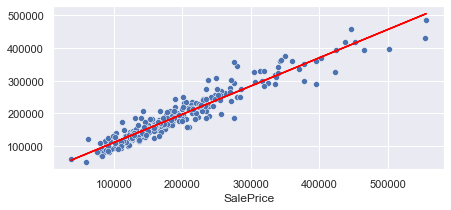

In [27]:
acc = pd.DataFrame({'y_test':y_test_exp, 'preds':preds_exp})
m,b = np.polyfit(acc['y_test'],acc['preds'],1)

fig = plt.figure(figsize=(7,3))
sns.scatterplot(x=y_test_exp,y=preds_exp)
plt.plot(acc['y_test'], m*acc['y_test'] + b, color='red')

# Fit on Entire Dataset

In [28]:
model.fit(X, y)

LGBMRegressor(learning_rate=0.12, max_depth=5, n_estimators=200, num_leaves=5)

**Apply Feature Engineering**

In [29]:
test = pd.read_csv('./data/test.csv')
test = feat_eng(test, obj_cols, test_set = True)

In [30]:
test_cols = [col for col in train.columns if col != 'SalePrice']

values = model.predict(test[test_cols])
values_exp = np.exp(values)

pd.DataFrame({'Id':test['Id'], 'SalePrice':values_exp}).set_index('Id', drop=True).to_csv('preds.csv')

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

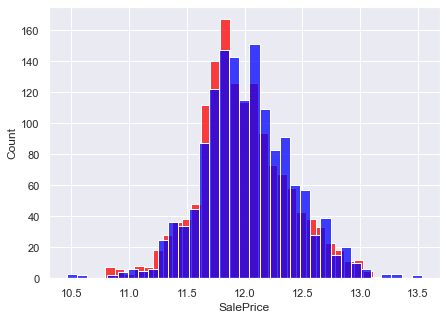

In [31]:
fig,axs = plt.subplots(1,figsize=(7,5))
sns.histplot(values, color='red')
sns.histplot(train['SalePrice'], color='blue')